In [1]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    RobustScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import CLEANED_DATA, FINAL_MODEL

from src.graphics import (
    plot_coefficients,
    plot_compare_model_metrics,
    plot_estimator_residuals,
)
from src.helpers import (
    dataframe_coefficients,
    grid_search_cv_regressor,
    organize_results,
    train_and_validate_regression_model,
)

df = pd.read_parquet(CLEANED_DATA)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

Creating variables to store the columns for the model.

In [3]:
target_column = ["median_house_value"]

one_hot_encoder_column = ["ocean_proximity"]

ordinal_encoder_column = ["median_income_cat"]

Previous tests were conducted before arriving at the following code.

Working with categorical variables and applying robust scaler to numerical columns is better than trying to optimize each numerical column individually.

In [4]:
robust_scaler_columns = df.columns.difference(target_column + one_hot_encoder_column + ordinal_encoder_column)

robust_scaler_columns

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

The preprocessing with the best performance was the preprocessing with robust scaler. RobustScaler handles housing data outliers effectively.

Working with polynomial features along with this preprocessing.

To apply polynomial features to numerical columns, a pipeline is created performing scaling separately and creating them, subsequently passing to preprocessing.

In [5]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessing = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), ordinal_encoder_column),
        ("one_hot", OneHotEncoder(drop="first"), one_hot_encoder_column),
        ("robust_scaler_poly", pipeline_robust, robust_scaler_columns),
    ],
)

In [6]:
X = df.drop(columns=target_column)
y = df[target_column]

Creating parameter grid.

Polynomial degree: Limited to 3 max - above this, interpretation becomes difficult and overfitting risk increases.

Alpha (Ridge regularization): Tests [0.01-50] to find optimal balance - shrinks less important coefficients toward zero, highlighting the most impactful features for house price prediction.

In [7]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

In [8]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessing,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

Quantile Transformer has better parameters than PowerTransformer.

In [9]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 10.0}

The degree found captures complex patterns without overfitting.

High value alpha but not the highest possible indicates strong Ridge regularization - shrinks ~80% of coefficients, focusing on key housing features (income, rooms/household).

In [11]:
grid_search.best_score_

np.float64(-50447.163223966556)

This represents the best (lowest error) among tested configurations.

In [12]:
coefs = dataframe_coefficients(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coefficient
robust_scaler_poly__longitude,-1.030967
robust_scaler_poly__latitude,-0.961549
one_hot__ocean_proximity_INLAND,-0.466336
robust_scaler_poly__latitude longitude population_per_household,-0.419686
robust_scaler_poly__population_per_household,-0.334790
...,...
robust_scaler_poly__latitude^2 longitude,0.249540
robust_scaler_poly__latitude median_income population_per_household,0.249543
robust_scaler_poly__housing_median_age median_income,0.249873
robust_scaler_poly__bedrooms_per_room,0.338883


367 coefficients coming from 14 columns with the found degree, makes sense but is a problematic number for interpreting the result.

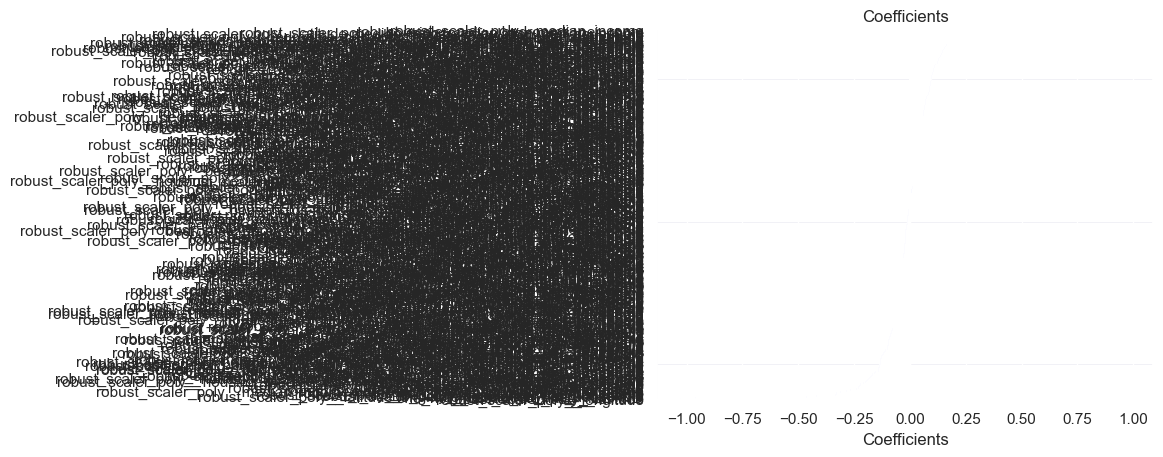

In [13]:
plot_coefficients(coefs)

The number of coefficients is too large to create a graph.

In [14]:
coefs[coefs["coefficient"] == 0]

,coefficient


The fact that there are no zero coefficients indicates that no specific feature is unimportant, moreover Ridge reduces coefficients without zeroing them out.

Checking coefficients within a certain range to see if it's possible to eliminate small coefficients.

In [15]:
coefs[coefs["coefficient"].between(-0.2, 0.2) & (coefs["coefficient"] != 0)]

,coefficient
one_hot__ocean_proximity_NEAR BAY,-0.199441
robust_scaler_poly__housing_median_age population_per_household total_bedrooms,-0.196205
robust_scaler_poly__longitude median_income,-0.193562
robust_scaler_poly__households median_income^2,-0.186957
robust_scaler_poly__housing_median_age median_income population_per_household,-0.181498
...,...
robust_scaler_poly__total_bedrooms,0.170038
robust_scaler_poly__median_income population population_per_household,0.175603
robust_scaler_poly__bedrooms_per_room rooms_per_household total_bedrooms,0.175611
robust_scaler_poly__median_income population rooms_per_household,0.176143


Outside the 0.2 range, a more interpretable number of coefficients remains.

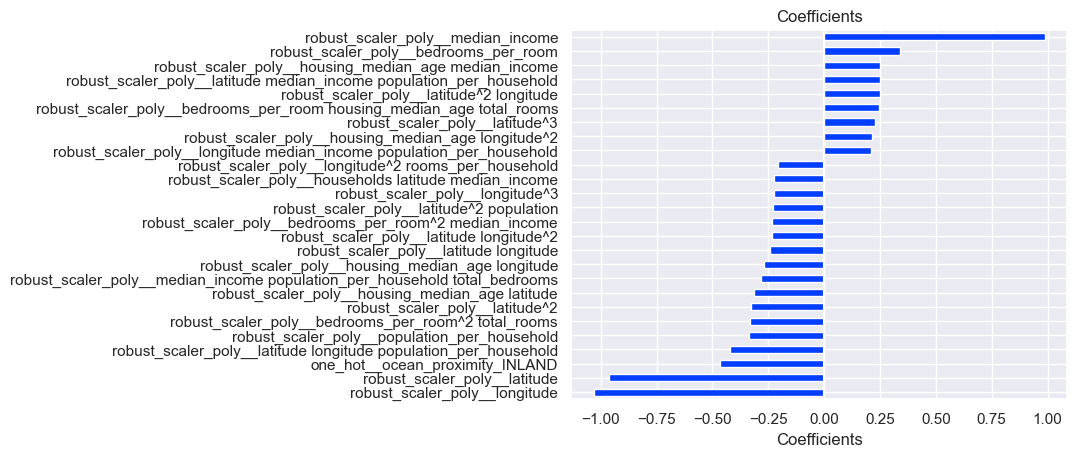

In [16]:
plot_coefficients(coefs[~coefs["coefficient"].between(-0.2, 0.2)])

Average income and location are the main factors for understanding house values. Latitude and longitude combine several times with other features, demonstrating how much they affect the model's outcome.

Comparing the more elaborate model with the simpler one to verify whether adding complexity is worthwhile.

In [17]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessing,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessing,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "Ridge_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

results = {
    model_name: train_and_validate_regression_model(X, y, **regressor)
    for model_name, regressor in regressors.items()
}

df_results = organize_results(results)

df_results

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.008584,0.00719,-0.000081,-77516.042766,-96239.705692,0.015774
1,DummyRegressor,0.002431,0.0,-0.000146,-75787.787194,-95217.629397,0.002431
2,DummyRegressor,0.008391,0.005774,-0.001737,-76753.598961,-96253.253947,0.014166
3,DummyRegressor,0.003647,0.004034,-0.000101,-76837.804811,-95983.885799,0.007681
4,DummyRegressor,0.002998,0.005774,-0.000114,-76617.245449,-96182.764729,0.008773
5,LinearRegression,0.165254,0.016529,0.682162,-39855.690996,-54254.958188,0.181782
6,LinearRegression,0.034088,0.017652,0.66999,-40272.565467,-54695.230283,0.051739
7,LinearRegression,0.048234,0.016802,0.649247,-42178.05929,-56955.988706,0.065036
8,LinearRegression,0.058582,0.023792,0.669873,-40806.492497,-55146.318803,0.082373
9,LinearRegression,0.072946,0.025134,0.669023,-40788.496497,-55331.35106,0.09808


Analyzing the mean.

In [18]:
df_results.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00521,0.004555,-0.000436,-76702.495836,-95975.447913,0.009765
LinearRegression,0.075821,0.019982,0.668059,-40780.26095,-55276.769408,0.095802
LinearRegression_target,0.112947,0.030301,0.677947,-38683.694353,-54443.337574,0.143248
Ridge_grid_search,1.566034,0.026986,0.723114,-35340.742505,-50473.108138,1.593021


When sorted, an improvement in the model is observed.

In [19]:
df_results.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00521,0.004555,-0.000436,-76702.495836,-95975.447913,0.009765
LinearRegression,0.075821,0.019982,0.668059,-40780.26095,-55276.769408,0.095802
LinearRegression_target,0.112947,0.030301,0.677947,-38683.694353,-54443.337574,0.143248
Ridge_grid_search,1.566034,0.026986,0.723114,-35340.742505,-50473.108138,1.593021


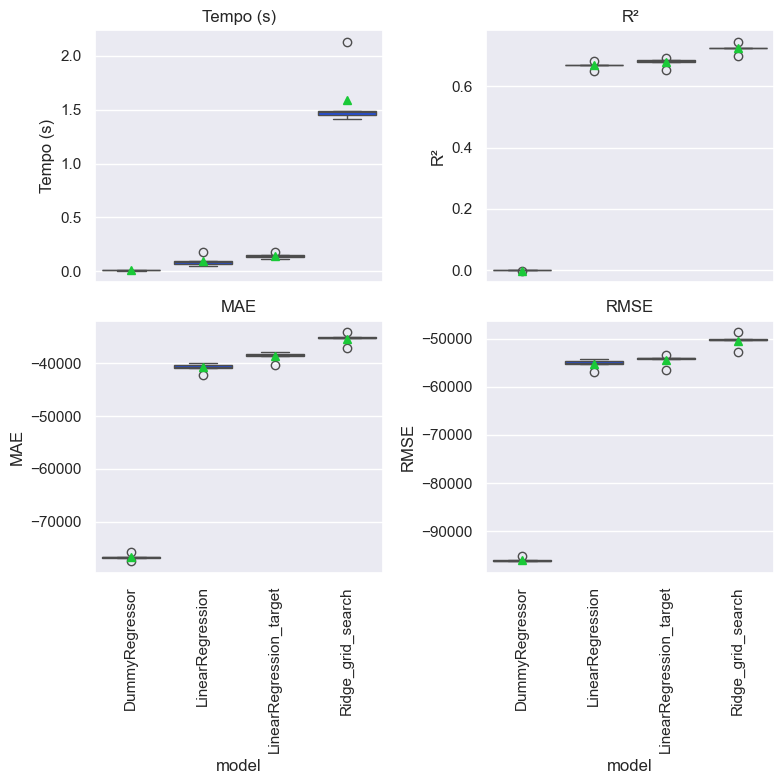

In [20]:
plot_compare_model_metrics(df_results)

Ridge is slower than the others but achieves a better metric for the model.

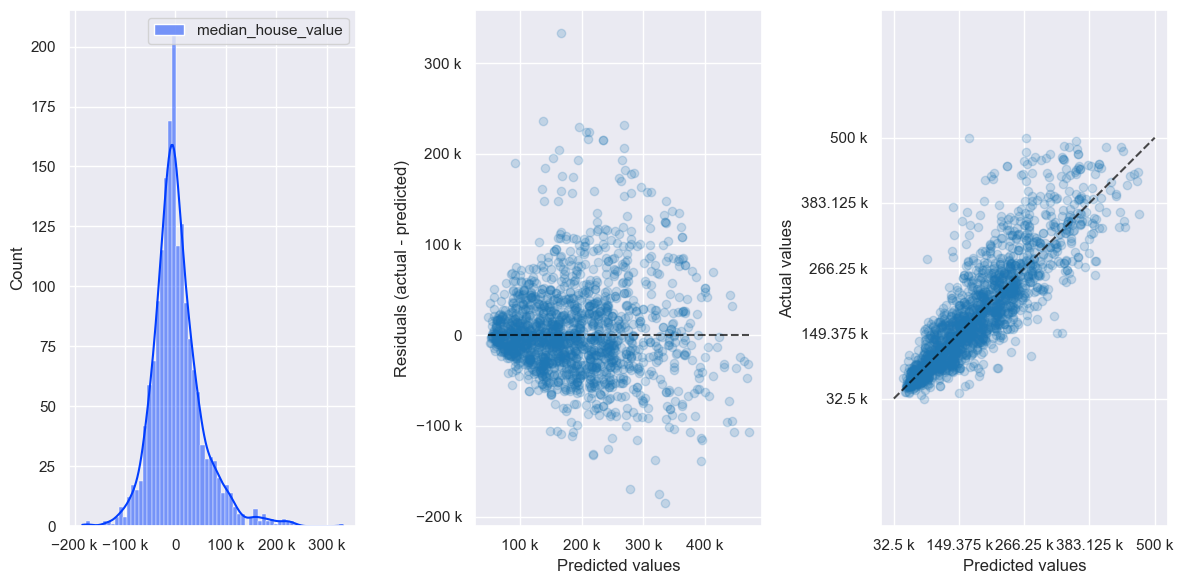

In [21]:
plot_estimator_residuals(grid_search.best_estimator_, X, y, sample_fraction=0.1, eng_formatter=True)

The points accumulate much more along the zero line and the upward reference line with some errors, but the model still continues to improve.

From this point, further optimization is still possible, but significant improvements are unlikely to be found.

This study began with extensive exploratory analysis, evaluated geographical data, and progressed to using machine learning.

Optimization Journey Summary:

The process started as simply as possible with minimal preprocessing of categorical columns;

Followed by experimenting with target transformation and determining the best one, in this case Quantile;

Simple preprocessing was developed for numerical columns and a more elaborate one to handle numerical data according to skewness;

The simple approach was selected and chosen along with the previous target transformation;

Polynomial features were tested, which ended up slightly improving the model while increasing process complexity;

How regularization affects the model was verified, with Ridge performing the best.

In [23]:
#dump(grid_search.best_estimator_, FINAL_MODEL)